In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from keras.applications import MobileNetV2, ResNet50, EfficientNetB0, InceptionV3, DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import keras_cv


2024-12-30 10:15:34.717226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-30 10:15:34.726890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735533934.738225   87186 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735533934.741835   87186 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 10:15:34.753989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:


def get_preprocessing_function(base_model_name):
    if base_model_name == 'MobileNetV2':
        return mobilenet_preprocess
    elif base_model_name == 'ResNet50':
        return resnet_preprocess
    elif base_model_name == 'EfficientNetB0':
        return efficientnet_preprocess
    elif base_model_name == 'InceptionV3':
        return inception_preprocess
    elif base_model_name == 'DenseNet121':
        return densenet_preprocess
    else:
        raise ValueError("Unsupported model: " + base_model_name)

def train_model(
    base_model_name='MobileNetV2',  # Base model to use
    train_dir='./PlantVillage/train',  # Path to training dataset
    test_dir='./PlantVillage/test',  # Path to testing dataset
    model_save_name='best_model.keras',  # File name to save the best model
    image_size=(224, 224),  # Image size to resize
    batch_size=32,  # Batch size for training
    validation_split=0.2,  # Validation split
    epochs=10,  # Number of epochs
    learning_rate=0.001,  # Learning rate
    patience=5,  # Patience for early stopping
    use_focal_loss=False  # Use focal loss to handle class imbalance
):

    train_dataset = image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset="training",
        seed=123
    )
    class_names = train_dataset.class_names

    validation_dataset = image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        validation_split=validation_split,
        subset="validation",
        seed=123
    )

    test_dataset = image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size
    )

    # Calculate class weights
    class_counts = np.zeros(len(class_names), dtype=np.int64)
    
    for _, labels in train_dataset:
        for label in labels.numpy():
            class_counts[label] += 1
    class_weights = compute_class_weight('balanced', classes=np.arange(len(class_names)), y=np.repeat(np.arange(len(class_names)), class_counts))
    class_weights = {i: weight for i, weight in enumerate(class_weights)}
    print(class_weights)

    preprocess_fn = get_preprocessing_function(base_model_name)

    def preprocess_image(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = preprocess_fn(image)
        if use_focal_loss:
            label = tf.one_hot(label, depth=len(class_names))  # One-hot encode labels
        return image, label


    train_dataset = train_dataset.map(preprocess_image).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.map(preprocess_image).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(preprocess_image).prefetch(buffer_size=tf.data.AUTOTUNE)

    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    elif base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    else:
        raise ValueError("Unsupported model: " + base_model_name)

    base_model.trainable = False

    loss_fn = (
        keras_cv.losses.FocalLoss(alpha=0.25, gamma=2.0) if use_focal_loss 
        else 'sparse_categorical_crossentropy'
    )

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')  # Adjust for number of classes
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss= loss_fn,
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_save_name,
        monitor='val_loss',
        save_best_only=True
    )

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce the learning rate by 0.5
        patience=2,  # Wait epochs before reducing learning rate
        min_lr=1e-5  # Minimum learning rate
    )

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler],
        class_weight= class_weights
    )

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


Found 20401 files belonging to 17 classes.
Using 16321 files for training.
Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 576 files belonging to 17 classes.


2024-12-30 10:19:20.693727: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{0: np.float64(19.201176470588237), 1: np.float64(5.39358889623265), 2: np.float64(1.2076211616722161), 3: np.float64(0.8262124126759137), 4: np.float64(1.2261287656825182), 5: np.float64(10.213391739674593), 6: np.float64(1.2732875643626151), 7: np.float64(0.5687552272093671), 8: np.float64(1.238785578747628), 9: np.float64(0.764378044211315), 10: np.float64(0.6408937406738396), 11: np.float64(1.3044277493606138), 12: np.float64(3.47847399829497), 13: np.float64(0.6892023140914657), 14: np.float64(0.8824070069204152), 15: np.float64(0.7362414290869722), 16: np.float64(0.3854110090443243)}
Epoch 1/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.4055 - loss: 1.9778 - val_accuracy: 0.7740 - val_loss: 0.7999 - learning_rate: 0.0050
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.5162 - loss: 1.4082 - val_accuracy: 0.7850 - val_loss: 0.7138 - learning_rate: 0.0050
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.4909 - loss: 1.3974 - val_a

2024-12-30 10:21:35.294527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6012 - loss: 1.0755 - val_accuracy: 0.8581 - val_loss: 0.5044 - learning_rate: 0.0025
Epoch 10/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6074 - loss: 1.0512 - val_accuracy: 0.8556 - val_loss: 0.4889 - learning_rate: 0.0025
Epoch 11/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.5987 - loss: 1.0565 - val_accuracy: 0.8632 - val_loss: 0.4815 - learning_rate: 0.0025
Epoch 12/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6126 - loss: 1.0457 - val_accuracy: 0.8659 - val_loss: 0.4820 - learning_rate: 0.0025
Epoch 13/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.6244 - loss: 0.9611 - val_accuracy: 0.8652 - val_loss: 0.4873 - learning_rate: 0.0025
Epoch 14/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6215 - loss: 0.9864 - val_accuracy: 0.8819 - val_loss: 0.4190 - learning_rate: 0.0012
Epoch 15/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6475 - loss: 

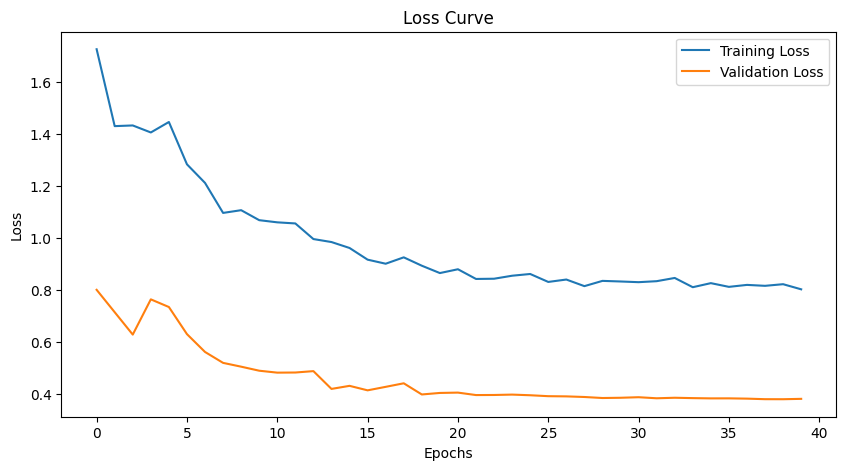

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8751 - loss: 0.5711
Test Accuracy: 87.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Classification Report:
                                     precision    recall  f1-score   support

                00 Chilli - Healthy       0.92      0.52      0.67        23
        01 Chilli - Leaf Curl Virus       0.

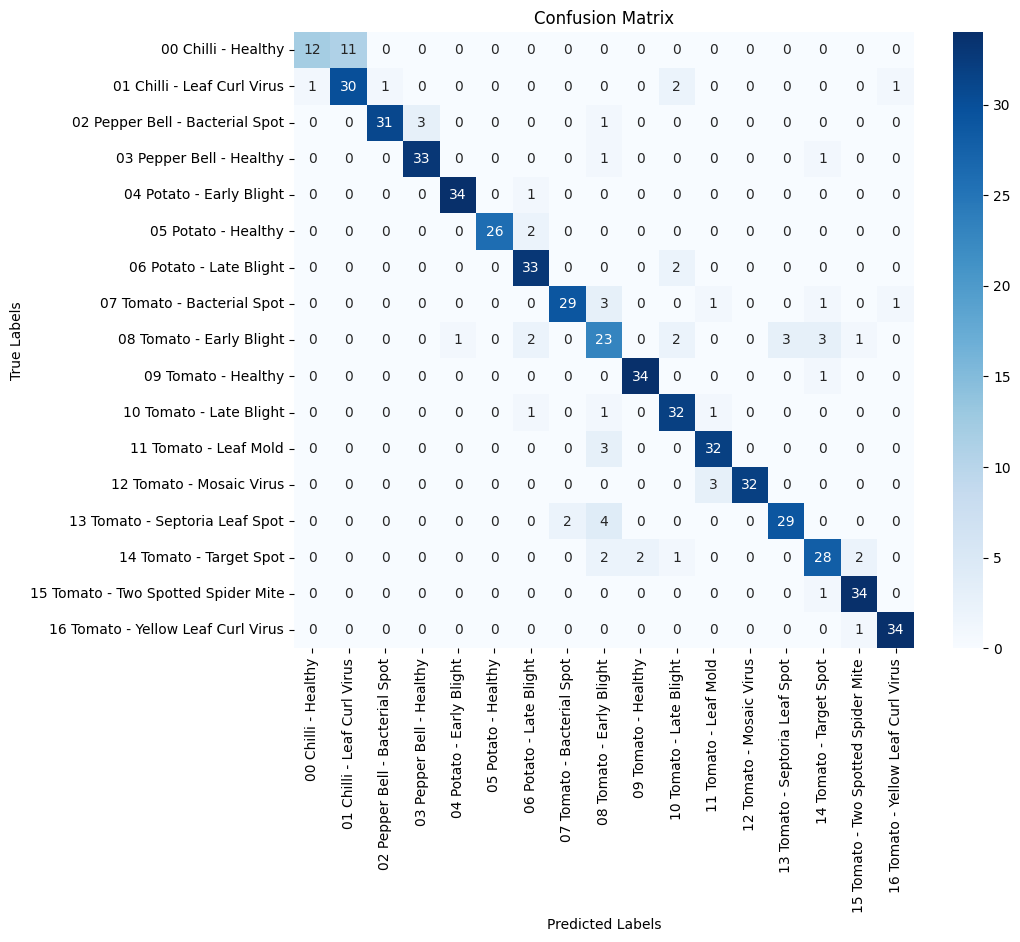

In [4]:
train_model(
    base_model_name='MobileNetV2',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/test',
    model_save_name='best_mnv2_model_lt.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=5,
)

In [ ]:
train_model(
    base_model_name='ResNet50',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/train',
    model_save_name='best_rn50_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=5,
    use_focal_loss=True
)

Found 20401 files belonging to 17 classes.
Using 16321 files for training.
Found 20401 files belonging to 17 classes.
Using 4080 files for validation.
Found 20401 files belonging to 17 classes.
Epoch 1/40


2024-12-30 00:39:08.817936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5284_0', 112 bytes spill stores, 224 bytes spill loads

2024-12-30 00:39:08.891146: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8147', 24 bytes spill stores, 24 bytes spill loads

2024-12-30 00:39:08.908066: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5284', 220 bytes spill stores, 576 bytes spill loads

2024-12-30 00:39:08.956193: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8147', 60 bytes spill stores, 64 bytes spill loads



511/511 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.5431 - loss: 1.4995 - val_accuracy: 0.8897 - val_loss: 0.3406 - learning_rate: 0.0050
Epoch 2/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.7184 - loss: 0.8150 - val_accuracy: 0.9196 - val_loss: 0.2884 - learning_rate: 0.0050
Epoch 3/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.7700 - loss: 0.6521 - val_accuracy: 0.9000 - val_loss: 0.3067 - learning_rate: 0.0050
Epoch 4/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.7750 - loss: 0.6270 - val_accuracy: 0.9248 - val_loss: 0.2392 - learning_rate: 0.0050
Epoch 5/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.7955 - loss: 0.5910 - val_accuracy: 0.9314 - val_loss: 0.2154 - learning_rate: 0.0050
Epoch 6/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.8124 - loss: 0.5584 - val_accuracy: 0.9228 - val_loss: 0.2376 - learning_rate: 0.0050
Epoch 7/40
511/511 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.8117 - loss: 0.5451

KeyboardInterrupt: 

In [ ]:


train_model(
    base_model_name='EfficientNetB0',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/train',
    model_save_name='best_en_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=5,
    use_focal_loss=True
)

In [ ]:


train_model(
    base_model_name='InceptionV3',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/train',
    model_save_name='best_inv3_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    patience=5,
    use_focal_loss=True
)

In [ ]:

train_model(
    base_model_name='DenseNet121',
    train_dir='./PlantVillage/train',
    test_dir='./PlantVillage/train',
    model_save_name='best_dn121_model.keras',
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    epochs=40,
    learning_rate=0.005,
    use_focal_loss=True
    patience=5
)